In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

import sscFresnel
import pynx

import timeit
from pylab import *
# The following import will use CUDA if available, otherwise OpenCL
from pynx.wavefront import *
%matplotlib widget

In [2]:
# -*- coding: utf-8 -*-

# manage the imports
import numpy as np
import matplotlib.pyplot as plt
import os
import time


# %load_ext autoreload
# %reload_ext autoreload

# FRESNEL PROPAGATOR

# function [Ef,x,y,G,E0fft,fx,fy,H,indx] = FresnelPropagator(E0, ps, lambda0, z, background)
#
# This function computes the double-slit diffraction pattern using the 
# Fresnel Approximation. This code was modified from Dan and Aamod's
# Fresnel propagator codes.
#
# Parameters: E0 - initial complex field in x-y source plane
#             ps - pixel size in microns
#             lambda0 - wavelength in nm
#             z - z-value (distance from sensor to object)
#             background - optional background image to divide out from
#                          input field
#
# Returns: Ef - 
#          x - 
#          y - 
#          G - 
#          E0fft - 
#          fx - 
#          fy - 
#          H - 
#

def abssqr(x):
    # this is what a detector sees (only intensities)
    return np.real(x*np.conj(x))

def FT(x):
    # this only defines the correct fwd fourier transform including proper shift of the frequencies
    return np.fft.fftshift(np.fft.fft2(x)) # Fourier transform and shift

def iFT(x):
    # this only defines the correct inverse fourier transform including proper shift of the frequencies
    return np.fft.ifft2(np.fft.ifftshift(x)) # inverse Fourier transform and shift
    
def FresnelPropagator(E0, ps, lambda0, z):
    # Parameters: E0 - initial complex field in x-y source plane
    #             ps - pixel size in microns
    #             lambda0 - wavelength in nm
    #             z - z-value (distance from sensor to object)
    #             background - optional background image to divide out from
    #                
    
    upsample_scale = 1;                 # Scale by which to upsample image
    n = upsample_scale * E0.shape[1] # Image width in pixels (same as height)
    grid_size = ps * n;                 # Grid size in x-direction
    

    # Inverse space
    fx = np.linspace(-(n-1)/2*(1/grid_size), (n-1)/2*(1/grid_size), n)
    fy = np.linspace(-(n-1)/2*(1/grid_size), (n-1)/2*(1/grid_size), n)
    Fx, Fy = np.meshgrid(fx, fy)
    
    # Fresnel kernel / point spread function h = H(kx, ky)
    # from Fourier Optics, chapter 4
    # H = sqrt(z*lambda0)*exp(1i*pi*lambda0*z*(Fx.^2+Fy.^2));
    # sphere=exp(i*k/2/zc*(xx.^2+yy.^2));
    H = np.exp(1j * np.pi * lambda0 * z * (Fx**2 + Fy**2))
    #H= cos(pi*lambda0*z*(Fx.^2+Fy.^2)+(2*pi*z)/lambda0)+1i.*sin(pi*lambda0*z*(Fx.^2+Fy.^2)+(2*pi*z)/lambda0);
    # Compute FFT centered about 0
    E0fft = FT((E0));     # Centered about 0 since fx and fy centered about 0
    
    # Multiply spectrum with fresnel phase-factor
    G = H * E0fft
    Ef = iFT(G)#*np.exp(1j*(2 * np.pi / lambda0) * z) # Output after deshifting Fourier transform
    
    return Ef

In [3]:
def eV_to_meters(energy):
    c = 299792458               # Speed of light [m/s]
    plank = 4.135667662E-15     # Planck's constant [ev*s]
    wavelength =  plank * c / energy
    return wavelength

In [4]:
N = 300
obj = np.zeros((N,N))+1j
n = 50
obj[n:-n,n:-n] = 1 + 1j

energy = 22e3 # eV
z1 = 500e-3
z2 = 1+z1 # meters
wavelength = eV_to_meters(energy)
pixel_size = 1.44e-6

magnification = (z1+z2)/z1

Fr = pixel_size**2 / ( wavelength * z2 )
print(f"Fresnel number = {Fr}")

ZeroDivisionError: float division by zero

### Comparing different packages

In [5]:
import cupy as cp

def fresnel_propagator_cone_beam(wavefront, wavelength, pixel_size, sample_to_detector_distance, source_to_sample_distance = 0):

    np = cp.get_array_module(wavefront) # make code agnostic to cupy and numpy
    
    K = 2*np.pi/wavelength # wavenumber
    z2 = sample_to_detector_distance
    z1 = source_to_sample_distance
    
    if z1 != 0:
        M = 1 + (z2/z1)
    else:
        M = 1
    
    FT = np.fft.fftshift(np.fft.fft2(wavefront))

    ny, nx = wavefront.shape
    fx = np.fft.fftshift(np.fft.fftfreq(nx,d = pixel_size/M))#*2*np.pi 2*np.pi factor to calculate angular frequencies 
    fy = np.fft.fftshift(np.fft.fftfreq(ny,d = pixel_size/M))#*2*np.pi
    FX, FY = np.meshgrid(fx,fy)
    # kernel = np.exp(-1j*(z2/M)/(2*K)*(FX**2+FY**2)) # if using angular frequencies (add 2pi terms for fx, fy above). Formula as in Paganin equation 1.28
    kernel = np.exp(-1j*np.pi*wavelength*(z2/M)*(FX**2+FY**2)) # if using standard frequencies. Formula as in Goodman, Fourier Optics, equation 4.21

    wave_parallel = np.fft.ifft2(np.fft.ifftshift(FT * kernel))*np.exp(1j*K*z2/M) 

    if z1 != 0:
        gamma_M = 1 - 1/M
        y, x = np.indices(wavefront.shape)
        y = (y - y.shape[0]//2)*pixel_size/M
        x = (x - x.shape[1]//2)*pixel_size/M
        wave_cone = wave_parallel * (1/M) #* np.exp(1j*gamma_M*K*z2)* np.exp(1j*gamma_M*K*(x**2+y**2)/(2*z2)) # CHECK commented phase terms for complete form of the Fresnel Scaling theorem!
        return wave_cone
    else:
        return wave_parallel

In [6]:
propagated_wavefront = fresnel_propagator_cone_beam(obj,wavelength,pixel_size, z2,source_to_sample_distance=z1)
propagated_wavefront_back = fresnel_propagator_cone_beam(propagated_wavefront,wavelength,pixel_size, -z2,source_to_sample_distance=-z1)


propagated_wavefrontB = fresnel_propagator_cone_beam(obj,wavelength,pixel_size/magnification, z2/magnification,source_to_sample_distance=0)
propagated_wavefront_backB = fresnel_propagator_cone_beam(propagated_wavefront,wavelength,pixel_size/magnification, -z2/magnification,source_to_sample_distance=0)

propagated_wavefront3 = FresnelPropagator(obj, pixel_size/magnification, wavelength, z2/magnification)
propagated_wavefront3_back = FresnelPropagator(propagated_wavefront3, pixel_size/magnification, wavelength, -z2/magnification)

dic = {}
dic['gpu'] = [0]
dic['blocksize'] = 1
dic['normX'] = 0
dic['zeropadding'] = (0,0,0,0)
dic['rotationdetector'] = (0,0,0)
dic['poni'] = (0,0)
dic['samplemasscenter'] = (0,0)
dic['z1'] = (z1,z1)
dic['z2'] = (z2,z2)
dic['detpixelsize'] = (pixel_size,pixel_size)
dic['energy'] = energy
# dic['beamgeometry'] = 'parallel'
dic['beamgeometry'] = 'conebeam'

inputobj = np.expand_dims(obj,axis=0)
propagated_wavefront2 = np.squeeze(sscFresnel.propagation.propagation_projection(inputobj, dic)[0])
dic['z1'] = (z1,z1)
dic['z2'] = (-z2,-z2)
propagated_wavefront2_back = np.squeeze(sscFresnel.propagation.propagation_projection(propagated_wavefront2, dic)[0])

w = Wavefront(d=obj, pixel_size=pixel_size/magnification, wavelength=wavelength)
w = PropagateNearField(z2/magnification,magnification=None, verbose=True) * w
propagated_pynx = w.get()

w = Wavefront(d=propagated_pynx[0], pixel_size=pixel_size/magnification, wavelength=wavelength)
w = PropagateNearField(-z2/magnification,magnification=None, verbose=True) * w
propagated_pynx_back = w.get()



2024-04-01 15:28:21,814 - sscFresnel.fresneltypes - DEBUG - Conebeam geometry selected
2024-04-01 15:28:21,818 - sscFresnel.fresneltypes - DEBUG - Conebeam geometry selected
Near field propagation: |z=-1.500000| < 2.759577 ?


RuntimeError: VkFFT error 4039: VKFFT_ERROR_FAILED_TO_LAUNCH_KERNEL C2C (1,300,300) complex64 2D inplace [cuda]

Text(0, 0.5, 'Backward')

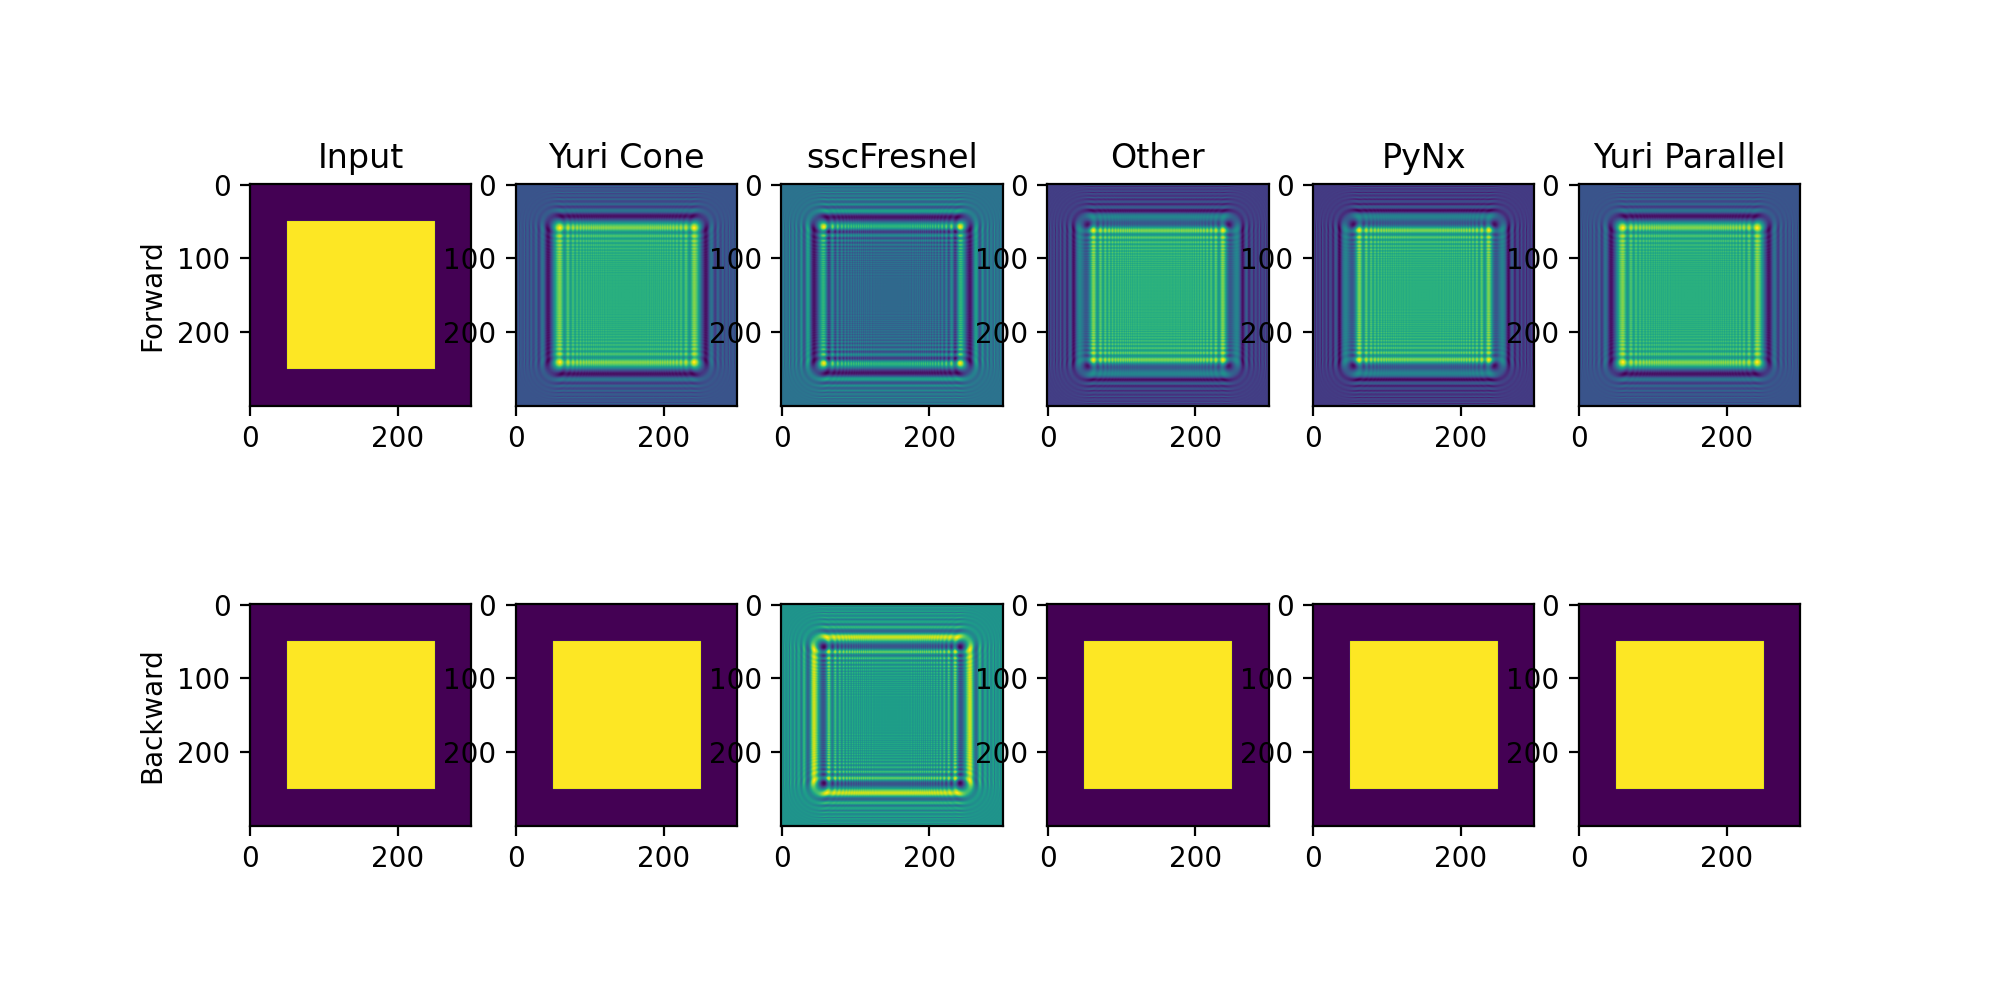

In [ ]:
fig, ax = plt.subplots(2,6,figsize=(10,5),dpi=200)
ax[0,0].imshow(np.abs(obj)), ax[0,0].set_title('Input')
ax[1,0].imshow(np.abs(obj))

ax[0,1].imshow(np.abs(propagated_wavefront)), ax[0,1].set_title('Yuri Cone')
ax[1,1].imshow(np.abs(propagated_wavefront_back))

ax[0,2].imshow(np.abs(propagated_wavefront2)), ax[0,2].set_title('sscFresnel')
ax[1,2].imshow(np.abs(propagated_wavefront2_back))

ax[0,3].imshow(np.abs(propagated_wavefront3)), ax[0,3].set_title('Other')
ax[1,3].imshow(np.abs(propagated_wavefront3_back))

ax[0,4].imshow(np.abs(propagated_pynx[0])), ax[0,4].set_title('PyNx')
ax[1,4].imshow(np.abs(propagated_pynx_back[0]))


ax[0,5].imshow(np.abs(propagated_wavefrontB)), ax[0,5].set_title('Yuri Parallel')
ax[1,5].imshow(np.abs(propagated_wavefront_backB))

ax[0,0].set_ylabel('Forward')
ax[1,0].set_ylabel('Backward')

# for ax in ax.ravel():
#     ax.set_xticks([])
#     ax.set_yticks([])